In [14]:
!pip install --upgrade hmmlearn

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


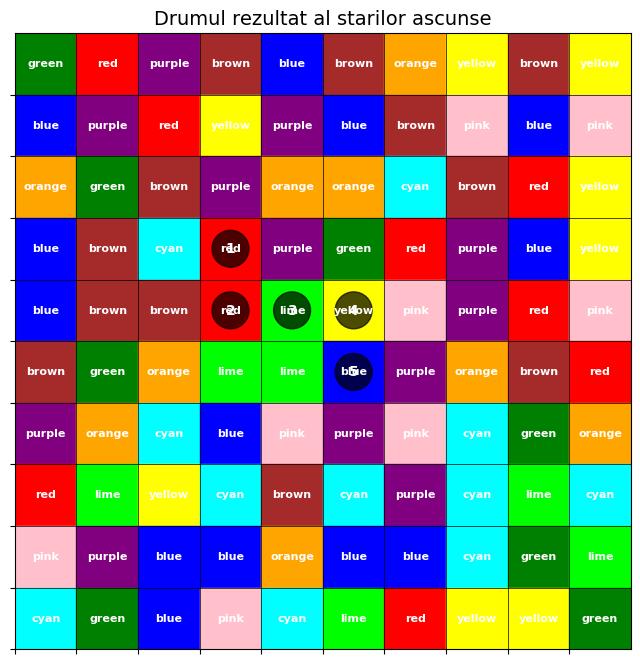

In [27]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dimensiunea gridului (o matrice de 10x10)
dimensiune_grid = (10, 10)

# Lista culorilor posibile in grid
culori = [
    "red", "blue", "green", "yellow",
    "purple", "orange", "pink", "cyan",
    "brown", "lime"
]

# 1. Citirea gridului
df = pd.read_csv('grid_culori.csv', header=None)  # Citeste fisierul care contine culorile gridului
grid_culori = df.to_numpy()  # Converteste gridul in format numpy array (pentru procesare rapida)

# 2. Verificarea dimensiunii gridului pentru conformitate
if grid_culori.shape != dimensiune_grid:  # Daca dimensiunea din CSV nu este de 10x10
    raise ValueError(f"Dimensiunea grilei ({grid_culori.shape}) nu corespunde cu {dimensiune_grid}.")

# 3. Observatiile culorilor vazute de agent
observatii = ["red", "red", "lime", "yellow", "blue"]

# 4. Maparea culorilor in indecsi si invers
culoare_to_idx = {culoare: idx for idx, culoare in enumerate(culori)}  # Creeaza un dictionar {culoare: index}
idx_to_culoare = {idx: culoare for culoare, idx in culoare_to_idx.items()}  # Creeaza maparea inversa {index: culoare}

# 5. Transformarea observatiilor in format "one-hot"
# Exemplu: "red" devine [1, 0, 0, 0, ..., 0] (valoare 1 pentru "red")
observatii_one_hot = np.zeros((len(observatii), len(culori)))  # Creeaza un array zero (n_observatii x n_culori)
for i, culoare in enumerate(observatii):  # Parcurgem observatiile
    observatii_one_hot[i, culoare_to_idx[culoare]] = 1  # Setam 1 la indexul corespunzator culorii

# 6. Definim starile ascunse: toate pozitiile posibile din grid (100 pozitii)
numar_stari = dimensiune_grid[0] * dimensiune_grid[1]  # Totalul starilor = 10 x 10 = 100
stari_ascunse = [(i, j) for i in range(dimensiune_grid[0]) for j in range(dimensiune_grid[1])]  # Lista cu toate coordonatele (i, j)
stare_to_idx = {stare: idx for idx, stare in enumerate(stari_ascunse)}  # Creeaza un dictionar {stare: index}
idx_to_stare = {idx: stare for stare, idx in stare_to_idx.items()}  # Creeaza maparea inversa {index: stare}

# 7. Matricea de tranzitie intre starile ascunse
transitions = np.zeros((numar_stari, numar_stari))  # Matrice goala de 100x100
for i, j in stari_ascunse:  # Parcurgem fiecare pozitie (i, j)
    vecini = [
        (i - 1, j),  # Vecinul de sus
        (i + 1, j),  # Vecinul de jos
        (i, j - 1),  # Vecinul din stanga
        (i, j + 1)   # Vecinul din dreapta
    ]
    # Filtram doar vecinii valizi (care sunt in interiorul gridului)
    vecini_valizi = [stare_to_idx[(x, y)] for x, y in vecini if 0 <= x < 10 and 0 <= y < 10]
    # Pentru fiecare vecin valid, adaugam tranzitia
    for vecin in vecini_valizi:
        transitions[stare_to_idx[(i, j)], vecin] = 1

# Eliminam posibilitatea agentului de a merge la stanga
# Comentand aceasta sectiune, agentul NU va mai putea merge la stanga:
# vecini = [
#     (i - 1, j),  # Vecinul de sus
#     (i + 1, j),  # Vecinul de jos
#     (i, j + 1)   # Vecinul din dreapta (eliminam "j - 1")
# ]



# Normalizam matricea de tranzitie pentru a avea probabilitati (suma fiecarui rand = 1)
transitions = transitions / transitions.sum(axis=1, keepdims=True)

# 8. Matricea de emisie (legatura dintre stari ascunse si observatii)
emissions = np.zeros((numar_stari, len(culori)))  # Matrice goala (100 x 10)
for i, j in stari_ascunse:
    culoare = grid_culori[i, j]  # Culoarea asociata pozitiei (i, j)
    emissions[stare_to_idx[(i, j)], culoare_to_idx[culoare]] = 1  # Setam 1 pentru emisia corespunzatoare

# 9. Configurarea modelului HMM
model = hmm.MultinomialHMM(n_components=numar_stari, n_iter=100, tol=1e-4)  # Initializam modelul
model.startprob_ = np.ones(numar_stari) / numar_stari  # Probabilitate uniforma pentru starea initiala
model.transmat_ = transitions  # Setam matricea de tranzitie
model.emissionprob_ = emissions  # Setam matricea de emisie
model.n_trials = 1  # Fiecare observatie este un singur eveniment

# 10. Rulam algoritmul Viterbi pentru observatii
logprob, secventa_stari = model.decode(observatii_one_hot, algorithm="viterbi")

# 11. Convertim starile ascunse in coordonate din grid
drum = [idx_to_stare[idx] for idx in secventa_stari]  # Convertim indexii starilor in pozitii (i, j)

# 12. Vizualizarea drumului rezultat
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(dimensiune_grid[0]):
    for j in range(dimensiune_grid[1]):
        culoare = grid_culori[i, j]  # Culoarea celulei (i, j)
        ax.add_patch(plt.Rectangle((j, dimensiune_grid[0] - i - 1), 1, 1, color=culoare))  # Desenam fiecare celula
        ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, culoare,  # Afisam textul culorii in centru
                color="white", ha="center", va="center", fontsize=8, fontweight="bold")

# Evidentiem drumul rezultat al agentului
for idx, (i, j) in enumerate(drum):
    ax.add_patch(plt.Circle((j + 0.5, dimensiune_grid[0] - i - 0.5), 0.3, color="black", alpha=0.7))  # Cercuri pe drumul agentului
    ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, str(idx + 1),  # Afisam ordinea pasilor
            color="white", ha="center", va="center", fontsize=10, fontweight="bold")

# Configurari axa si grid
ax.set_xlim(0, dimensiune_grid[1])
ax.set_ylim(0, dimensiune_grid[0])
ax.set_xticks(range(dimensiune_grid[1]))
ax.set_yticks(range(dimensiune_grid[0]))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(visible=True, color="black", linewidth=0.5)
ax.set_aspect("equal")
plt.title("Drumul rezultat al starilor ascunse", fontsize=14)
plt.show()







Daca agentul nu va putea alege directia stanga indiferent de situatie, acest lucru va afecta posibilele trasee, deoarece anumite rute optime care treceau prin deplasarea spre stanga nu mai sint accesibile.

Rezultatul drumului:
Algoritmul Viterbi va cauta cel mai probabil traseu bazat pe observatii si pe matricea de tranzitie . Deoarece directia spre stanga este interzisa, drumul rezultat va evita complet miscarile spre stanga. Acest lucru poate duce la drumuri mai lungi sau mai complexe pentru a atinge aceeasi destinate.

Probabilitatea totala:
Probabilitatea drumului rezultat poate scadea